In [33]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from datetime import datetime
from math import *

date_format = "%m/%d/%Y"

In [34]:
class Bond():
    def __init__(self, data):
        self.coupon = float(data[0])
        self.matur = datetime.strptime(data[1], date_format)
        self.prices = []
        for i in range(2, len(data)):
            self.prices.append(float(data[i]))

In [35]:
# Import and set up data
dates = ['1/10/2022', '1/11/2022', '1/12/2022', '1/13/2022', '1/14/2022', 
         '1/17/2022', '1/18/2022', '1/19/2022', '1/20/2022', '1/21/2022']
formatted_dates =  []
for d in dates:
    a = datetime.strptime(d, date_format)
    formatted_dates.append(a)
    
bonds = []
with open('selected_bonds.csv', newline='') as filename:
    csvreader = csv.reader(filename)
    for row in csvreader:
        b = Bond(row)
        bonds.append(b)

In [36]:
# Calculate yield curve
def yield_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= 100 * exp(-rate * t)
    while t > 0:
        ans -= coupon * exp(-rate * t)
        t -= 0.5
    return ans

def find_yield_rate(price, coupon, matur, cur_date):
    """
    find_yield_rate uses binary search to find the ytm
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = yield_equation(price, coupon / 2, matur, cur_date, mid)
        # divide coupon by 2 since there are 2 coupon payments per year
        if abs(ans) < 0.0001:
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
yields = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    for b in bonds:
        r = find_yield_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    yields.append(day_curve)
    times.append(matur_times)

print(yields[0])

[1.53076171875, 0.8676147460937499, 0.9992980957031253, 1.13037109375, 1.2099456787109375, 1.365509033203125, 1.5107345581054688, 1.4911651611328125, 1.490478515625, 1.5983200073242185, 1.6588592529296877]


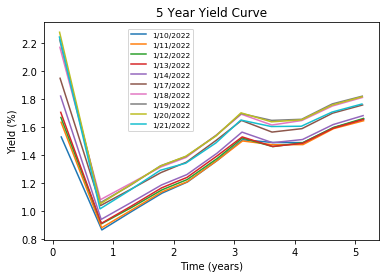

In [37]:
# Plot yield curve
for i in range(len(yields)):
    plt.plot(times[i], yields[i], label=dates[i])
plt.title("5 Year Yield Curve")
plt.xlabel("Time (years)")
plt.ylabel("Yield (%)")
plt.legend(loc = (0.25, 0.5), prop={'size': 7.5})
plt.savefig('yield.png')

# Yield curve has up and down movement since not all bonds have exact same coupon.

In [38]:
# calculate spot curve
spot_rates = []
def spot_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= (100 + coupon) * exp(-rate * t)
    t -= 0.5
    i = 0
    while t > 0: # discount coupon at the corresponding spot rate
        ans -= coupon * exp(-spot_rates[i] * t)
        i += 1
        t -= 0.5
    return ans

def find_spot_rate(price, coupon, matur, cur_date):
    """
    Use binary search to find the spot rate from the spot equation
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = spot_equation(price, coupon / 2, matur, cur_date, mid) 
        # divide coupon by 2 since there are 2 coupon payments per year
        if abs(ans) < 0.0001:
            spot_rates.insert(0, mid)
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
spots = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    spot_rates = []
    for b in bonds:
        r = find_spot_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    spots.append(day_curve)
    times.append(matur_times)
    
print(spots[0])
# spot rates are slightly different from ytm
# the later spot rates are larger than ytm which is to be expected

[1.53076171875, 0.8673095703125, 0.9992980957031253, 1.13067626953125, 1.2102508544921877, 1.367645263671875, 1.5160751342773438, 1.4928436279296873, 1.491241455078125, 1.603317260742187, 1.6662979125976565]


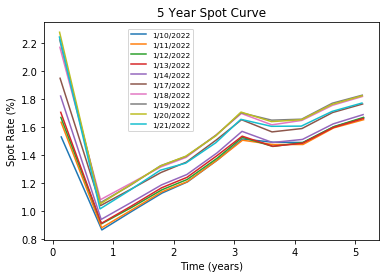

In [39]:
# Plot spot curve
for i in range(len(spots)):
    plt.plot(times[i], spots[i], label=dates[i])
plt.title("5 Year Spot Curve")
plt.xlabel("Time (years)")
plt.ylabel("Spot Rate (%)")
plt.legend(loc = (0.25, 0.5), prop={'size': 7.5})
plt.savefig('spot.png')

In [40]:
# calculate forward curve

year_spot_rates = []
for i in range(len(dates)):
    # interpolate spot rates to exactly 1 year marks
    spots_today = []
    s = spots[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        s1 = s[2*j-1]
        s2 = s[2*j]
        ratio = (j-t1) / (t2-t1)
        spot = ratio * s1 + (1 - ratio) * s2
        spots_today.append(spot)
    year_spot_rates.append(spots_today)

forwards = []
years = []
# calculate forward rates
for i in range(len(formatted_dates)):
    spots_today = year_spot_rates[i]
    forward = []
    for j in range(1, 5):
        f = (spots_today[j] * (j+1) - spots_today[0]) / (j)
        forward.append(f)
    forwards.append(forward)
    years.append([1,2,3,4])

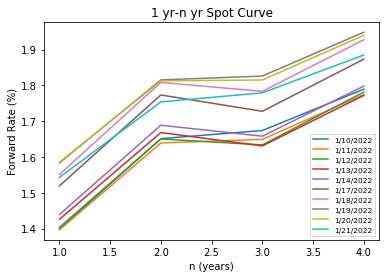

In [41]:
# Plot forward curve
for i in range(len(forwards)):
    plt.plot(years[i], forwards[i], label=dates[i])
plt.title("1 yr-n yr Spot Curve")
plt.xlabel("n (years)")
plt.ylabel("Forward Rate (%)")
plt.legend(prop={'size': 7.5})
plt.savefig('forward.png')

In [42]:
# Calculate yield covariance and get eigenvalues/eigenvectors
def calculate_covariance(r1, r2):
    ans = np.dot(r1, r2) / len(r1)
    return ans

# interpolate to find n year yields
year_yield_rates = []
for i in range(len(dates)):
    yield_today = []
    y = yields[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        y1 = y[2*j-1]
        y2 = y[2*j]
        ratio = (j-t1) / (t2-t1)
        yiel = ratio * y1 + (1 - ratio) * y2
        yield_today.append(yiel)
    year_yield_rates.append(yield_today)

yield_returns = []
for i in range(5): # calculate log returns
    y = []
    for j in range(len(dates)-1):
        x = log(year_yield_rates[j+1][i] / year_yield_rates[j][i])
        y.append(x)
    yield_returns.append(y)

cov1 = []
for i in range(5): # calculate covariance matrix
    row = []
    for j in range(5):
        x = calculate_covariance(yield_returns[i], yield_returns[j])
        row.append(x)
    cov1.append(row)

print("Covariance Matrix for Yield")
for row in cov1:
    print(row)
    
# eigenvectors from np.linalg.eig are the columns (not the rows)
w, v = np.linalg.eig(cov1)
print()
print("Eigenvalues and Eigenvectors")
for i in range(5):
    print(w[i], 10*v[:,i])

Covariance Matrix for Yield
[0.0013238290341469675, 0.0009788828523989409, 0.0008695503480694306, 0.0007030946080317892, 0.000732802403057814]
[0.0009788828523989409, 0.0007710536471655349, 0.0006795837408086863, 0.0005820314107652092, 0.000580422151896352]
[0.0008695503480694306, 0.0006795837408086863, 0.0006130543148296219, 0.0005172670465049115, 0.0005240000557692361]
[0.0007030946080317892, 0.0005820314107652092, 0.0005172670465049115, 0.000529430608910699, 0.0004913846949130438]
[0.000732802403057814, 0.000580422151896352, 0.0005240000557692361, 0.0004913846949130438, 0.00048551992305421424]

Eigenvalues and Eigenvectors
0.003542857349340539 [-5.98158652 -4.62933033 -4.12497606 -3.58415062 -3.59560289]
0.000141020619446483 [ 5.97321376  0.49196386  0.19588257 -7.07165354 -3.74593582]
2.2603893196183652e-05 [-4.93297735  6.2107325   4.71648942 -1.79906272 -3.4074385 ]
3.228266187412164e-06 [ 1.24124526 -5.017141    5.36082033  3.76667296 -5.51011674]
1.3177399936420137e-05 [-1.6329

In [43]:
# Calculate forward covariance and get eigenvalues/eigenvectors
forward_x = []
for i in range(4): # calculate log returns
    f = []
    for j in range(len(dates)-1):
        x = log(forwards[j+1][i] / forwards[j][i])
        f.append(x)
    forward_x.append(f)

cov2 = []
for i in range(4): # calculate covariance matrix
    row = []
    for j in range(4):
        x = calculate_covariance(forward_x[i], forward_x[j])
        row.append(x)
    cov2.append(row)

print("Covariance Matrix for Forward Rates")
for row in cov2:
    print(row)
w, v = np.linalg.eig(cov2)
print()
print("Eigenvalues and Eigenvectors")
for i in range(4):
    print(w[i], 10*v[:,i])

Covariance Matrix for Forward Rates
[0.0005427556326187568, 0.0004833839578922666, 0.0004448123461087861, 0.0004314287296548348]
[0.0004833839578922666, 0.00047113442384511927, 0.000401607219261443, 0.0004178151478414601]
[0.0004448123461087861, 0.000401607219261443, 0.0004750264522020162, 0.0004199433382424743]
[0.0004314287296548348, 0.0004178151478414601, 0.0004199433382424743, 0.0004188762364417201]

Eigenvalues and Eigenvectors
0.0017800637572297732 [5.35991122 4.9919015  4.88805676 4.73911091]
8.635758894611348e-05 [ 4.366001    4.71454323 -7.27750319 -2.39772074]
3.545928041180173e-05 [ 6.32465638 -4.21100916  2.97149818 -5.7824149 ]
5.912118519924154e-06 [ 3.49401039 -5.92633136 -3.7835231   6.19317697]
